# **Final exam - Laplace Redux**

## Implementing Bayesian Deep Learning with Laplace Approximations

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from laplace import Laplace
from sklearn.metrics import accuracy_score

# Load the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 3444899.88it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 238885.90it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2171828.16it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2070259.59it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



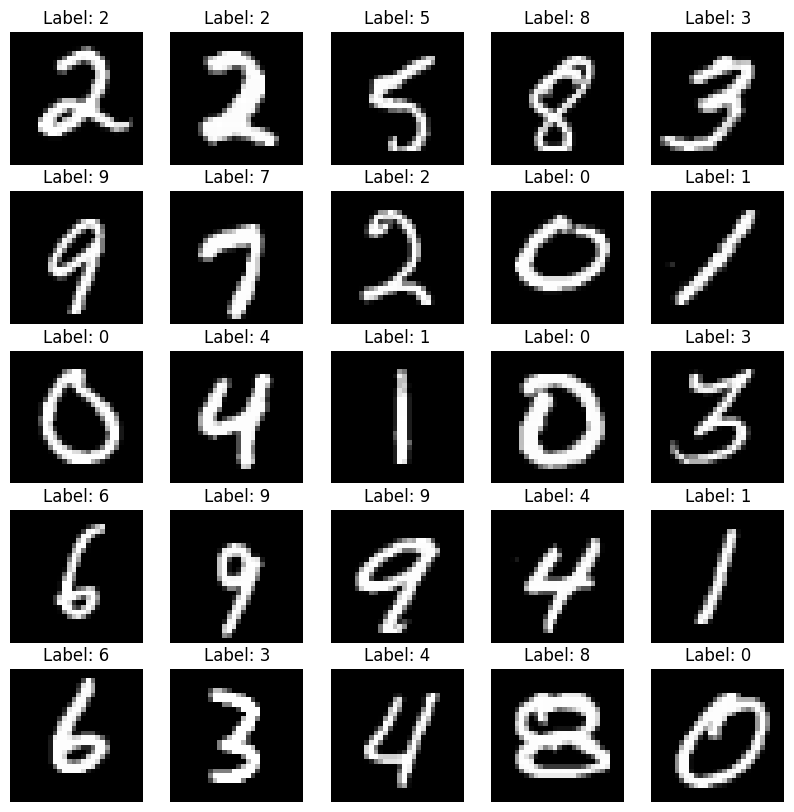

In [2]:
# View some images
import matplotlib.pyplot as plt
images, labels = next(iter(train_loader))
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f'Label: {labels[i]}')
    plt.axis('off')
plt.show()

In [3]:
# Define a simple feedforward neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Train the model
def train(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')


In [4]:
# Initialize the model, loss function and optimizer
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model, train_loader, criterion, optimizer)


Epoch 1/5, Loss: 0.06924102455377579
Epoch 2/5, Loss: 0.11613890528678894
Epoch 3/5, Loss: 0.4019003212451935
Epoch 4/5, Loss: 0.16500496864318848
Epoch 5/5, Loss: 0.009335344657301903


In [5]:
# Wrap the trained model with Laplace
la = Laplace(model, 'classification', subset_of_weights='last_layer', hessian_structure='diag')

# Use the training data to fit the Laplace approximation
la.fit(train_loader)

In [6]:
# Function to evaluate the Laplace-approximated model
def evaluate_laplace(la, test_loader):
    la.model.eval()  # Put the original model in evaluation mode
    all_preds = []
    all_targets = []
    device = next(la.model.parameters()).device  # Get the device of the model parameters
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = la(data)  # Use the Laplace object for prediction
            _, predicted = torch.max(output, 1)
            all_preds.append(predicted.cpu())
            all_targets.append(target.cpu())
    
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    accuracy = accuracy_score(all_targets, all_preds)
    print(f'Accuracy: {accuracy * 100:.2f}%')

# Load test data
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Evaluate the Laplace-approximated model
evaluate_laplace(la, test_loader)


Accuracy: 96.97%


In [7]:
def predict_with_uncertainty(la, data_loader, n_samples=100):
    la.model.eval()
    all_mean_preds = []
    all_var_preds = []
    device = next(la.model.parameters()).device  # Get the device of the model parameters
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            samples = la.predictive_samples(data, n_samples=n_samples)
            mean_preds = samples.mean(0)
            var_preds = samples.var(0)
            all_mean_preds.append(mean_preds.cpu())
            all_var_preds.append(var_preds.cpu())

    mean_preds = torch.cat(all_mean_preds)
    var_preds = torch.cat(all_var_preds)
    return mean_preds, var_preds


In [8]:
# Get predictions with uncertainty
mean_preds, var_preds = predict_with_uncertainty(la, test_loader)

# Analyze predictions
print(f'Mean Predictions: {mean_preds}')
print(f'Variance of Predictions: {var_preds}')

Mean Predictions: tensor([[5.1209e-08, 3.4063e-08, 3.3349e-06,  ..., 9.9995e-01, 4.1425e-09,
         2.0428e-05],
        [1.9728e-06, 3.6638e-04, 9.9923e-01,  ..., 4.4052e-09, 2.9468e-05,
         2.7076e-10],
        [3.5114e-05, 9.5285e-01, 1.8925e-03,  ..., 1.4819e-02, 1.5759e-02,
         1.0374e-03],
        ...,
        [1.9251e-09, 1.9989e-09, 1.5301e-09,  ..., 3.4661e-05, 6.6674e-07,
         1.5515e-04],
        [7.3083e-05, 2.7689e-07, 6.2744e-08,  ..., 4.1296e-06, 1.0961e-04,
         1.1851e-09],
        [2.0159e-06, 1.9627e-08, 1.8815e-06,  ..., 5.4220e-11, 2.7511e-07,
         1.2258e-08]])
Variance of Predictions: tensor([[1.1096e-14, 2.8943e-15, 1.2070e-11,  ..., 1.3617e-09, 2.3804e-17,
         2.7687e-10],
        [2.1403e-11, 4.2435e-07, 5.3664e-07,  ..., 1.4119e-17, 4.4036e-10,
         1.4245e-19],
        [2.0496e-09, 3.0460e-04, 1.5256e-06,  ..., 3.9638e-05, 4.9882e-05,
         5.2450e-07],
        ...,
        [3.8896e-17, 1.8126e-17, 4.7626e-18,  ..., 2.2182